# Data Preprocessing for Pheweb

This jupyter notebook takes a directory of SNP-level data and reformats it in Pheweb's prefered style.

In [ ]:
import pandas as pd
import glob
import os
import json

# Define the folder path
folder_path = "raw_data"  # Change this to your actual folder path

# Get a list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read each CSV file and store them in a list
df_list = [pd.read_csv(file) for file in csv_files]

# Concatenate all DataFrames into one
df_combined = pd.concat(df_list, ignore_index=True)

# cleaning
df_combined = df_combined.assign(snp = df_combined.snp.str.replace('`', ''))

# add reference alleles
reference = pd.read_csv('reference_genome.csv')

# add onto main df
df_combined = df_combined.merge(reference, how = 'left')

# drop the n = 0 rows
df_combined = df_combined[df_combined.n_total > 0]

# Display the combined DataFrame
df_combined.head()

,phenotype,snp,adjustment,beta,OR,SE,p,type,n_total,n_cases,...,beta.random,OR.random,SE.random,p.random,description,group,reference_hg38,alternate_hg38,reference_hg19,alternate_hg19
0,110.00,16:4353432_T,none,-0.000151,0.999849,0.005953,0.979734,logistic,1237800,177241,...,0.006178,1.006197,0.012305,0.615617,Dermatophytosis / Dermatomycosis,infectious diseases,C,NaN,C,NaN
1,110.10,16:4353432_T,none,-0.000312,0.999688,0.006069,0.959032,logistic,1237416,170510,...,0.010304,1.010357,0.015522,0.506800,Dermatophytosis,infectious diseases,C,NaN,C,NaN
2,110.11,16:4353432_T,none,0.002182,1.002185,0.006721,0.745428,logistic,1251709,128081,...,0.009433,1.009478,0.016507,0.567693,Dermatophytosis of nail,infectious diseases,C,NaN,C,NaN
3,110.12,16:4353432_T,none,0.000275,1.000275,0.010969,0.980001,logistic,1251344,36804,...,0.018498,1.018670,0.022352,0.407917,Althete's foot,infectious diseases,C,NaN,C,NaN
4,110.13,16:4353432_T,none,0.027595,1.027980,0.016599,0.096426,logistic,1258137,13211,...,0.027595,1.027980,0.016599,0.096426,Dermatophytosis of the body,infectious diseases,C,NaN,C,NaN


The given SNP data is in the form "16:4353432_T", "Chromosome:Position_Nucleotide". The code below reformats and renames the columns	

In [16]:
# extract the SNP data
df_combined[['chrom', 'pos', 'alternate']] = df_combined.snp.str.extract(r'(\d+):(\d+)_([A-Za-z])')

# rename necessary cols
df_combined = df_combined.assign(

    # clean
    phenocode = df_combined.phenotype,
    phenostring = df_combined.description,
    clean_phenotype = df_combined.description.str.lower().str.replace('[ -]', '_', regex = True).str.replace("[',\\]\\[\\(\\)/;&\\.]", "", regex = True),

    # rename
    reference = df_combined.reference_hg19,
    num_samples = df_combined.n_total,
    num_controls = df_combined.n_controls,
    num_cases = df_combined.n_cases,
    se = df_combined.SE,

    maf = round(df_combined.assign(allele_freq2 = 1 - df_combined.allele_freq)[['allele_freq', 'allele_freq2']].min(axis = 1), 2),
    # maf = df_combined.allele_freq,

    # capitalize the first letter
    category = df_combined.group.str.slice(0,1).str.upper() + df_combined.group.str.slice(1),

    # retype
    chrom = df_combined.chrom.astype(int),
    pos = df_combined.pos.astype(int)
)

df_combined['or'] = df_combined.OR
df_combined['af'] = 1 - df_combined.maf

In [17]:
final_cols = [
    'chrom', 'pos', 'reference', 'alternate', 'p',
    'num_cases', 'num_controls', 'maf', 'af', 'beta', 'se', 'or'
]

Pheweb requires that the reference allele of the GWAS aligns with the reference allele of hg19 or hg18. If you have the reference allele and the alternate allele swapped, then you have to flip the effect size (beta). 

In [ ]:
# Where the reference allele equals the alternate allele, use the hg19 alternate allele
# swap the effect size sign
df_combined.loc[df_combined.reference == df_combined.alternate, 'beta'] = df_combined.loc[df_combined.reference == df_combined.alternate, 'beta'] * -1

# and change the odds ratio
df_combined.loc[df_combined.reference == df_combined.alternate, 'or'] =  1 / df_combined.loc[df_combined.reference == df_combined.alternate, 'or'] 

# and use the hg19 alternate allele 
df_combined.loc[df_combined.reference == df_combined.alternate, 'reference'] = df_combined.loc[df_combined.reference == df_combined.alternate, 'alternate_hg19']

Check that all SNPs have been successfully parsed.

In [ ]:
# check that we got all chromosomes
df_combined[df_combined.chrom.isna()][['snp'] + final_cols]


,snp,chrom,pos,reference,alternate,p,num_cases,num_controls,maf,af,beta,se,or


In [ ]:
# sort very important for Pheweb
df_combined = df_combined.sort_values(['phenocode', 'chrom', 'pos'])

In [23]:
# final file
df_combined[['phenocode', 'phenostring', 'clean_phenotype', 'category'] + final_cols].to_csv('all_data.csv', index = False)

<Axes: >

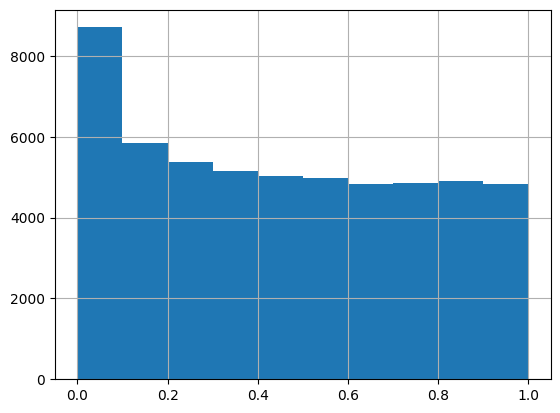

In [24]:
# note that the p-value is raw
df_combined.p.hist()

## Formatting 

Format the files per phenotype

In [ ]:
# do any phenocodes have zero samples? 
n_totals = df_combined.groupby('phenocode').n_total.sum()
pd.Series(n_totals[n_totals == 0].index)

Series([], Name: phenocode, dtype: float64)

In [26]:
unique_phenotypes = df_combined[['phenocode', 'phenostring', 'category', 'clean_phenotype']].drop_duplicates()

# check for consistent phenotype categories
if unique_phenotypes.shape[0] != df_combined.phenocode.nunique():
    raise ValueError("Non-unique phenotype categories. One or more phenotypes have multiple categories")

In [ ]:
# remove all files in the clean folder
import os
import glob

files = glob.glob('clean_data/*.csv')
for f in files:
    os.remove(f)

# make a file for each phenotype
for pheno in unique_phenotypes.clean_phenotype:
    df_combined[df_combined.clean_phenotype == pheno][final_cols].to_csv('clean_data/' + str(pheno) + '.csv', index = False)

## Create the Phenotype List for Pheweb

Though Pheweb has some ability to do this, I found making it myself to be easier

In [29]:
pheno_df = unique_phenotypes.assign(
    assoc_files = 'clean_data/' + unique_phenotypes.clean_phenotype + '.csv'
    )[['assoc_files',  'category', 'phenocode', 'phenostring']]

pheno_df.to_csv('pheno-list.csv', index = False)

In [ ]:
json_df = pheno_df.assign(phenocode = pheno_df.phenocode.astype(str))

# Ensure 'assoc_files' becomes a list of one file per row
json_df["assoc_files"] = json_df["assoc_files"].apply(lambda x: [x])

# Convert to list of dicts
pheno_json = json_df.to_dict(orient="records")

# Write to JSON file
with open("pheno-list.json", "w") as f:
    json.dump(pheno_json, f, indent=2)